# Análisis de un chat grupal de WhatsApp

Hacer este análisis ayuda a ver cuáles son las palabras más utilizadas por persona, los temas que se hablan, cuánto escribe cada uno, etc. <br>Además, se pueden hacer series de tiempo para predecir a futuro quién hablará e incluso el posible tema que tocará. <br>Se puede hacer un sentiment analysis para entender si son positivos o negativos los mensajes.

In [1]:
#Primero se cargan las librerías a usar:
library(timeDate)
library(dplyr) #Manipulación de Datos
library(stringr)
library(ggplot2) #Gráficas
library(plotly) #Más gráficas
library(lubridate) #Limpiar Fechas
library(tm)#Analisis de datos
library(wordcloud)
#Si no las tienes instaladas, usa la línea de código: install.packages("Nombre de la librería")

Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'stringr' was built under R version 3.5.3"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Loading required package: RColorBrewer


Se carga el texto del chat grupal. Dado que es un archivo TXT se carga como tabla. <br>
En este punto la tabla solamente tiene una columna porque el programa no sabe dónde dividir el texto de cada fila, por default se llamará esta columna "V1".

In [2]:
base <- read.table("https://raw.githubusercontent.com/Manamaster/analisisWhatsApp/master/WhatsAppChatArkha.txt", header=FALSE, sep="|", quote="", encoding='UTF-8')
head(base)

V1
"8/26/18, 1:51 PM - Messages to this group are now secured with end-to-end encryption. Tap for more info."
"9/14/17, 2:52 PM - E Sylvain created group ""El Arkha"""
"8/26/18, 1:51 PM - E Sylvain added you"
"8/27/18, 12:23 PM - E Sylvain: rol el domingo en mi casa"
"8/27/18, 12:24 PM - +52 1 55 2683 4746: Cool"
"8/27/18, 12:24 PM - +52 1 55 2683 4746: Yo le entro"


## Se separan los datos
### Creación de variable fecha
Se usan los números que se tomarán para la fecha son del 1 al 16 y 17 en este caso, dado que ese es el largo de la fecha: <br>
"9/14/17, 2:52 PM " <br>
Se extraen de V1, nombre por default de la columna extraida del TXT.

In [3]:
base$fecha <- gsub("\\.","",substr(base$V1, 1, 17)) #gsub busca un caracter y lo reemplaza.
head(base)

V1,fecha
"8/26/18, 1:51 PM - Messages to this group are now secured with end-to-end encryption. Tap for more info.","8/26/18, 1:51 PM"
"9/14/17, 2:52 PM - E Sylvain created group ""El Arkha""","9/14/17, 2:52 PM"
"8/26/18, 1:51 PM - E Sylvain added you","8/26/18, 1:51 PM"
"8/27/18, 12:23 PM - E Sylvain: rol el domingo en mi casa","8/27/18, 12:23 PM"
"8/27/18, 12:24 PM - +52 1 55 2683 4746: Cool","8/27/18, 12:24 PM"
"8/27/18, 12:24 PM - +52 1 55 2683 4746: Yo le entro","8/27/18, 12:24 PM"


Extraemos la parte de la persona y su mensaje

In [4]:
base<-base %>%
  mutate(texto=gsub("\\.:",":",substring(V1, 21)))%>%
  select(-V1)

Se eliminan los primeros 3 registros, ya que no contribuyen. <br>
Si existieran más líneas que no sirven (como aquellas donde dice: "Tal persona agregó a tal persona") se puede usar el código de esta manera:<br> "base[1:#,] <- NA", donde "#" es el número de fila hasta donde se borrará.

In [5]:
base[1:3,] <- NA

Se remueven los emoji y se mantiene el texto. <br>
Para esto se crea una columna nueva llamada "texto".

In [6]:
base$texto <- gsub("[^0-9A-Za-z///:áéíóúñ']"," " , base$texto ,ignore.case = TRUE)

Se cambian todos a mayúsculas para que no haga triplicados de palabras.

In [7]:
base$texto <- toupper(base$texto)

Se reemplazan los acentos con vocales sin acentos.

In [8]:
base$texto <- chartr('ÁÉÍÓÚ', 'AEIOU', base$texto)

Remover puntuación, palabras innecesarias y espacios en blanco. <br>
Las "stopwords" son palabras comunes que no son necesarias para el análisis del texto. 

In [9]:
head(base)

fecha,texto
NA,NA
NA,NA
NA,NA
"8/27/18, 12:23 PM",E SYLVAIN: ROL EL DOMINGO EN MI CASA
"8/27/18, 12:24 PM",52 1 55 2683 4746: COOL
"8/27/18, 12:24 PM",52 1 55 2683 4746: YO LE ENTRO


In [10]:
base$texto <- removeWords(base$texto, c(toupper(stopwords("spanish")),
                                              'OK', 'JAJA', 'JAJAJA', 'JAJAJAJA', 'MEDIA OMITTED'))
base$texto <- stripWhitespace(base$texto)
base$persona <- gsub(":.+$", "", base$texto)
base$mensaje <- gsub("^.+:", "", base$texto)

In [11]:
head(base)

fecha,texto,persona,mensaje
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
"8/27/18, 12:23 PM",SYLVAIN: ROL DOMINGO CASA,SYLVAIN,ROL DOMINGO CASA
"8/27/18, 12:24 PM",52 1 55 2683 4746: COOL,52 1 55 2683 4746,COOL
"8/27/18, 12:24 PM",52 1 55 2683 4746: ENTRO,52 1 55 2683 4746,ENTRO


Se hace un filtro para quitar los espacios vacíos en la variable mensaje y la palabra "añadió" del número (Cuando un usuario agrega a otro)

In [12]:
base <- base %>% 
  filter(!is.na(mensaje) | mensaje !="") %>% 
  filter(!str_detect(persona, 'AÑADIO')) %>% 
  filter(!str_detect(persona, 'ELIMINO'))

In [13]:
head(base)

fecha,texto,persona,mensaje
"8/27/18, 12:23 PM",SYLVAIN: ROL DOMINGO CASA,SYLVAIN,ROL DOMINGO CASA
"8/27/18, 12:24 PM",52 1 55 2683 4746: COOL,52 1 55 2683 4746,COOL
"8/27/18, 12:24 PM",52 1 55 2683 4746: ENTRO,52 1 55 2683 4746,ENTRO
"8/27/18, 12:24 PM",52 1 477 471 6688: MIENTRAS AGARRE DORMIDO TIEMPO IRE,52 1 477 471 6688,MIENTRAS AGARRE DORMIDO TIEMPO IRE
"8/27/18, 12:25 PM",52 1 55 2683 4746:,52 1 55 2683 4746,
"8/27/18, 12:28 PM",52 1 55 2534 4538: VA,52 1 55 2534 4538,VA


Borrar todos los mensajes vacíos si la columna "mensaje" = ""

In [14]:
base <- base %>% filter(!is.na(mensaje)|mensaje!="")
head(base)

fecha,texto,persona,mensaje
"8/27/18, 12:23 PM",SYLVAIN: ROL DOMINGO CASA,SYLVAIN,ROL DOMINGO CASA
"8/27/18, 12:24 PM",52 1 55 2683 4746: COOL,52 1 55 2683 4746,COOL
"8/27/18, 12:24 PM",52 1 55 2683 4746: ENTRO,52 1 55 2683 4746,ENTRO
"8/27/18, 12:24 PM",52 1 477 471 6688: MIENTRAS AGARRE DORMIDO TIEMPO IRE,52 1 477 471 6688,MIENTRAS AGARRE DORMIDO TIEMPO IRE
"8/27/18, 12:25 PM",52 1 55 2683 4746:,52 1 55 2683 4746,
"8/27/18, 12:28 PM",52 1 55 2534 4538: VA,52 1 55 2534 4538,VA


Creación de columna con formato date

In [15]:
base$fecha <- gsub("[^0-9A-Za-z///_áéíóúñ']","", base$fecha)
base$date <- as.Date(base$fecha, format = "%d/%m/%y")
class(base$date)

[1] "Date"

¿Quiénes son los participantes de este grupo de chat?

In [16]:
unique(factor(base$persona))
length(unique(base$persona))

[1]  SYLVAIN            52 1 55 2683 4746  52 1 477 471 6688  52 1 55 2534 4538
 [5]  52 1 55 7665 2023 52 1 55 7665 2023  ANDRES             SYLVAIN           
 [9] 2 1 55 1680 2055   2 1 55 2683 4746   52 1 55 2683 4746  52 1 477 471 6688 
[13] 52 1 55 2534 4538  52 1 55 1680 2055  2 1 477 471 6688   2 1 55 7665 2023  
[17]  52 1 55 1680 2055 NDRES               ANDRES            UELO JUGAR PLUMAS 
[21] 2 1 55 2534 4538   DRES               WIKI/ARSEPLOMANCER
23 Levels:  52 1 477 471 6688  52 1 55 1680 2055 ... WIKI/ARSEPLOMANCER

[1] 23

En este punto podemos determinar si el código ha funcionado con el dataset. ¿Cómo se determina esto? <br>
* Los datos que aparecen con el código "unique(factor(base$persona))" son solamente los números de teléfono o los nombres con los que se tienen registrados a los participantes de la conversación.
* No hay texto además de los nombres o números.

De ser así se puede continuar, sino, hay que observar si el corte fue el adecuado al momento de separar las columas "persona" y "mensaje"

## Análisis de los datos
Se toman a las personas que se quieran analizar:

In [17]:
levels(base$persona) <- c("SYLVAIN", "ANDRES", "NDRES", " SYLVAIN")

Se grafica la frecuencia de chateo de los participantes obtenidos en el paso anterior.

Warning message:
"Removed 114 rows containing non-finite values (stat_bin)."

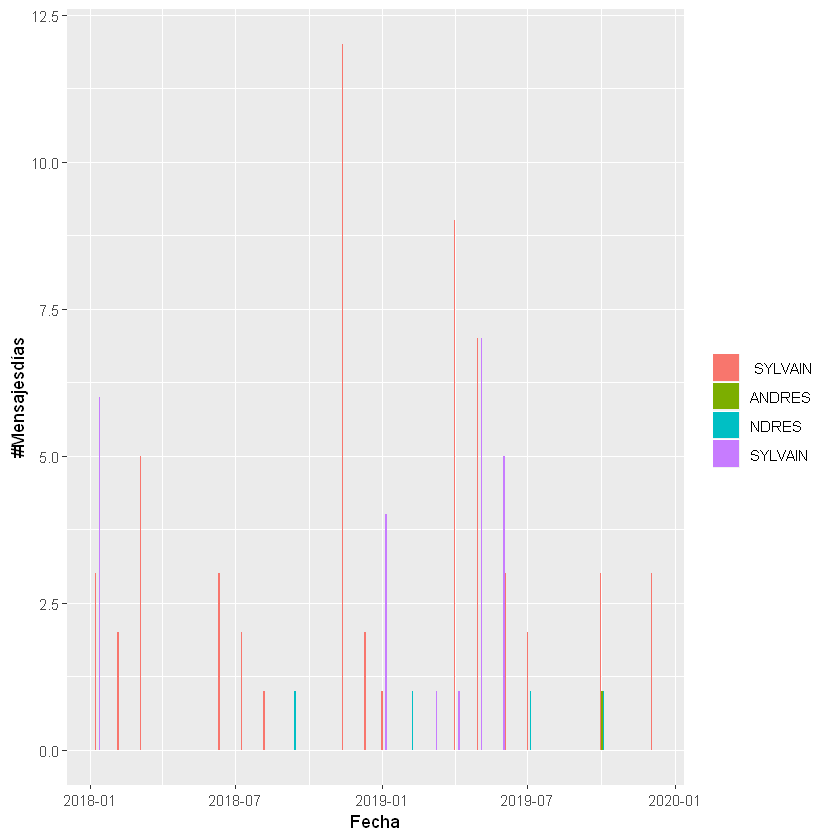

In [18]:
base <- base %>% filter(persona %in% c("SYLVAIN", "ANDRES", "NDRES", " SYLVAIN"))
ggplot(base, aes(x=date,fill=persona))+
  geom_histogram(binwidth = 7, position = 'dodge')+
  xlab("Fecha")+ylab("#Mensajesdías")+
  labs(fill="")

¿Cómo saber qué es lo que más comunmente ha dicho una persona?<br>
Para conseguir esto se generará una nube de palabras (wordcloud), a mayor tamaño de una palabra, más veces ha sido dicha por la persona que se está analizando. <br>Si hay muchas palabras como "jajajaja" se pueden remover en el paso 10 donde se agregaron manualmente las stopwords, para que no influyan en el resultado de la nube de palabras. <br>Si se quiere cambiar el color de las palabras en la nube se modifica la última sección del código, específicamente la palabra "Dark2". Para ver las paletas de colores disponibles entra aquí: https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf 

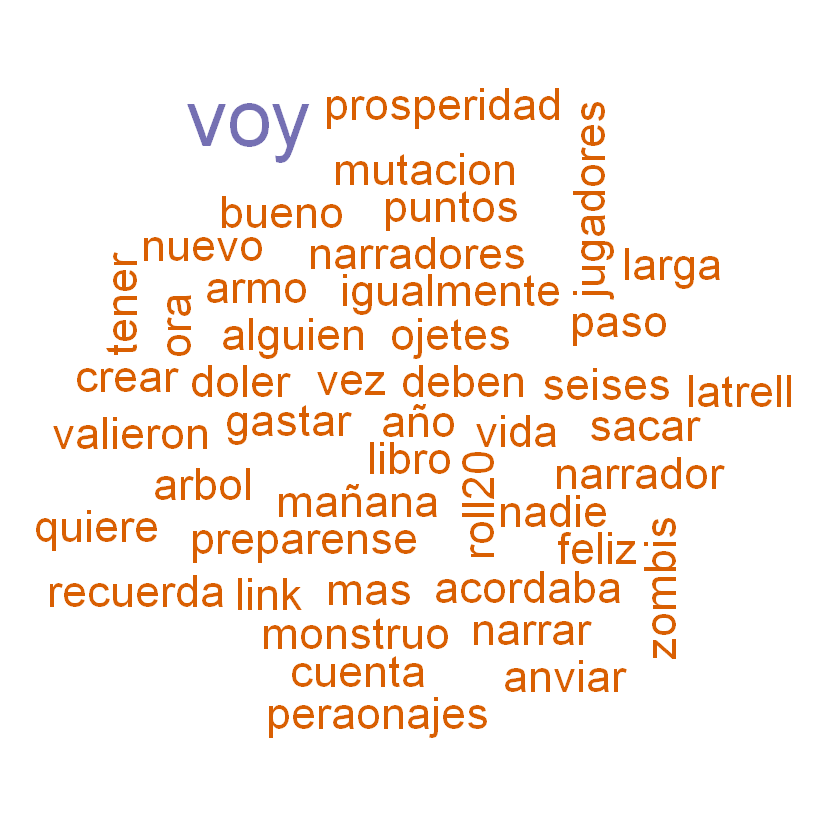

In [19]:
base_f <- base %>%
  filter(persona=="SYLVAIN")
dd <- data.frame(
  doc_id=base_f$persona,
  text=base_f$mensaje,
  stringsAsFactors = F
)

base1 <- VCorpus(DataframeSource(dd),
                 readerControl = list(language = "es"))
dtm <- DocumentTermMatrix(base1)


freq = data.frame(sort(colSums(as.matrix(dtm)), decreasing=TRUE))

wordcloud(rownames(freq), freq[,1], max.words=50, colors=brewer.pal(3, "Dark2"))

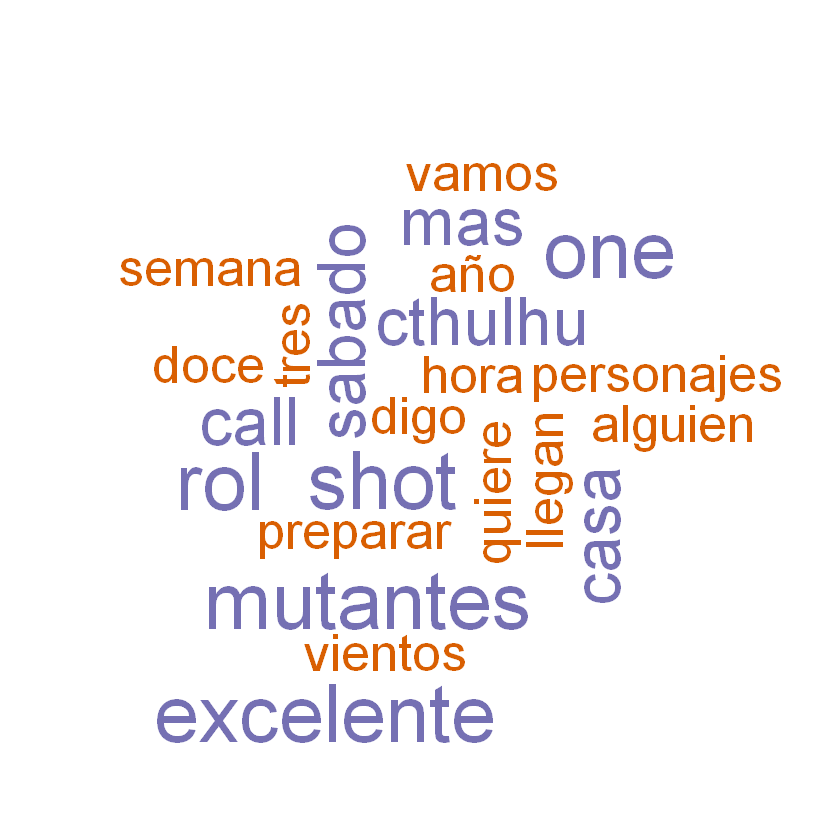

In [20]:
base_f <- base %>%
  filter(persona==" SYLVAIN")
dd <- data.frame(
  doc_id=base_f$persona,
  text=base_f$mensaje,
  stringsAsFactors = F
)

base1 <- VCorpus(DataframeSource(dd),
                 readerControl = list(language = "es"))
dtm <- DocumentTermMatrix(base1)


freq = data.frame(sort(colSums(as.matrix(dtm)), decreasing=TRUE))

wordcloud(rownames(freq), freq[,1], max.words=50, colors=brewer.pal(3, "Dark2"))

Llegando a este punto, donde se conocen a los participantes y las fechas en las cuales interactuaron, se pueden presentar las siguientes líneas de investigación:
* ¿Entre cuáles participantes hubo mayor comunicación mutua?
* ¿Cuáles fueron los horarios más comunes para el inicio de comunicaciones?
* ¿Cuáles fueron las palabras que concluyeron conversaciones? (Aquellas que no consiguieron una respuesta de sus pares pasado un cierto tiempo)
* ¿Cuál es la variedad del léxico de los participantes y la densidad de sus mensajes (cuántas palabras por mensaje ocupa)?
* ¿Cuáles son los horarios en los que se determina que hay más mensajes positivos y negativos?
* ¿Se puede predecir cuándo se hará otra invitación a una reunión y la fecha de dicha reunión?